<a href="https://colab.research.google.com/github/gmb408/OSSP-KBO-prediction/blob/version-0.1/Model_Building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 데이터 분석 모듈
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime

In [2]:
# 출력 할 때 마다, 기존 출력물들은 제거해주는 모듈
from IPython.display import clear_output

In [3]:
# 모델 모듈
from xgboost import XGBRegressor, plot_importance
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [4]:
result = pd.read_csv("/content/statiz_Final.csv", index_col=0)
result

,ID,이름,생일,팀,시즌,포지션,나이,G,타수,득점,...,타율_LAG1,출루_LAG1,장타_LAG1,OPS_LAG1,wOBA_LAG1,wRC+_LAG1,WAR+_LAG1,장타_NEXT,출루_NEXT,OPS_NEXT
0,0,이종범,1970-08-15,해,1994,SS,25,124.0,499.0,113.0,...,0.280,0.331,0.432,0.762,0.350,127.4,6.14,0.586,0.397,0.983
1,1,테임즈,1986-11-10,N,2015,1B,30,142.0,472.0,130.0,...,0.343,0.422,0.688,1.111,0.464,168.3,6.32,0.679,0.427,1.106
2,2,심정수,1975-05-05,현,2003,RF,29,133.0,460.0,110.0,...,0.321,0.404,0.643,1.047,0.440,177.7,7.45,NaN,NaN,NaN
3,0,이종범,1970-08-15,해,1997,SS,28,125.0,484.0,112.0,...,0.332,0.425,0.566,0.991,0.440,184.6,9.52,NaN,NaN,NaN
4,0,이종범,1970-08-15,해,1996,SS,27,113.0,449.0,94.0,...,0.326,0.397,0.586,0.983,0.432,181.9,5.03,0.581,0.428,1.009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5054,2187,임종찬,2001-09-28,한,2021,RF,21,42.0,132.0,9.0,...,0.231,0.297,0.306,0.602,0.283,61.5,-0.33,0.321,0.228,0.549
5055,1838,박찬호,1995-06-05,K,2020,SS,26,141.0,479.0,63.0,...,0.260,0.300,0.317,0.618,0.289,68.7,0.91,0.313,0.331,0.644
5056,1993,정보근,1999-08-31,롯,2020,C,22,85.0,133.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5057,1801,나종덕,1998-03-16,롯,2019,C,22,104.0,185.0,12.0,...,0.124,0.201,0.175,0.376,0.175,-15.1,-1.71,NaN,NaN,NaN


In [5]:
# 사용 features 명시
infos = ['ID','이름','생일','팀','시즌','포지션','나이']
stats = ['G','타수','득점','안타','1타','2타','3타','홈런','루타','타점','사사구','삼진','타율','출루','장타','OPS']

In [6]:
# 누적 및 lag stat features 이름
stats_cum = [i + '_누적' for i in stats]
stats_lag1 = [i + '_LAG1' for i in stats]
stats_lag2 = [i + '_LAG2' for i in stats]
stats_lag3 = [i + '_LAG3' for i in stats]

In [7]:
# X features와 y feature 정리
stats_position = ['2B', '3B', 'C', 'CF', 'DH', 'LF', 'RF', 'SS']
X_cols = stats + stats_cum + stats_lag1 + stats_lag2 + stats_position + ['나이'] 
y_cols = ['OPS_NEXT']
z_cols = stats + stats_cum + stats_lag1 + stats_lag2 +['나이']

resultdf = pd.DataFrame(data=result,columns=z_cols)
scaler = StandardScaler()
scaler.fit(resultdf)
results = scaler.transform(resultdf)
irisDF_scaled = pd.DataFrame(results,columns=z_cols)
result[z_cols] = irisDF_scaled[z_cols]
result

/usr/local/lib/python3.8/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.8/dist-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.8/dist-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count


,ID,이름,생일,팀,시즌,포지션,나이,G,타수,득점,...,3타_LAG2,홈런_LAG2,루타_LAG2,타점_LAG2,사사구_LAG2,삼진_LAG2,타율_LAG2,출루_LAG2,장타_LAG2,OPS_LAG2
0,0,이종범,1970-08-15,해,1994,SS,-0.956985,1.266397,1.996567,3.372978,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,테임즈,1986-11-10,N,2015,1B,0.182433,1.821340,1.801575,4.066844,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,심정수,1975-05-05,현,2003,RF,-0.045451,1.543869,1.714912,3.250531,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,이종범,1970-08-15,해,1997,SS,-0.273334,1.297227,1.888238,3.332162,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,이종범,1970-08-15,해,1996,SS,-0.501218,0.927265,1.635470,2.597480,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5054,2187,임종찬,2001-09-28,한,2021,RF,-1.868520,-1.261680,-0.653887,-0.871853,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5055,1838,박찬호,1995-06-05,K,2020,SS,-0.729102,1.790510,1.852129,1.332194,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5056,1993,정보근,1999-08-31,롯,2020,C,-1.640637,0.064019,-0.646665,-0.871853,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5057,1801,나종덕,1998-03-16,롯,2019,C,-1.640637,0.649793,-0.271123,-0.749406,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df = result.fillna(-1) # nan값 -1로 impute 
df = df[df['OPS_NEXT'] > 0] # 다음 해의 OPS가 존재하는 값들만 추출 (다음 해 OPS 가 없다면, predict 값과 target값을 비교 할 수 없기 때문)
df = pd.concat([df, pd.get_dummies(df['포지션'], drop_first=True)], axis=1) # 포지션 dummy variable로 변환


In [9]:
# 학습시킬 모델
from sklearn.ensemble import GradientBoostingRegressor
model_dict = {'xgb':XGBRegressor(n_estimators=110, learning_rate=0.05 ,max_depth=3, min_samples_split=400, random_state=23),
              'lgbm':LGBMRegressor(random_state=23),
              'rf':RandomForestRegressor(),
              'svr':SVR(),
              'knn':KNeighborsRegressor(),
              'reg':LinearRegression(),
              'ridge':Ridge(),
              'gbm' : GradientBoostingRegressor(random_state=23)
              }


In [10]:
# 2009 ~ 2016년 기간의 데이터로 검증
# 예를들어 2010년은 2009년까지의 데이터로, 2011년은 2010년까지의 데이터로 검증
# 에러가 가장 낮은 두 모델, xgboost와 ridge 중 ridge 선택
# ridge가 xgboost에 비해 과적합이 적고 일반화가 더 잘 이뤄졌을 것이라는 판단

test_error = []
r2 = []

for year in range(1984, 2022):

    train = df[df['시즌'] < year-1].reset_index(drop=True)
    test = df[df['시즌'] == year-1].reset_index(drop=True)
    
    X_train = train[X_cols]
    y_train = train[y_cols]

    X_test = test[X_cols]
    y_test = test[y_cols]
    
    model = model_dict['xgb']    #모델명 바꾸어 가면서 실험 가능
    model2 = model_dict['lgbm'] 
    model3 = model_dict['gbm']

    
    model.fit( X_train, y_train )
    model2.fit(X_train, y_train )
    model3.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    y_predict2 = model2.predict(X_test)
    y_predict3 = model3.predict(X_test)
    fin =  (y_predict *0.6) +  (y_predict2*0.2) +  (y_predict3*0.2)
    test_error.append(mean_squared_error(y_test,  fin,squared=False) )
    r2.append(r2_score(y_test, fin))

    clear_output(wait=True)
    print(year, ": 완료")
    
print("test error : ", np.mean(test_error))
print("RMSE : ", np.std(test_error))
print("r2 : ", np.mean(r2))
print("완료")

2021 : 완료
test error :  0.11143731160493543
RMSE :  0.012904256112635277
r2 :  0.2936964808812602
완료


In [11]:
# 연도별 테스트 에러
test_error

[0.14185397426893495,
 0.11026418398367423,
 0.11501159392150723,
 0.1029046986175239,
 0.11738928620430904,
 0.11756411722233386,
 0.1122661942253603,
 0.11612382105857622,
 0.10807614817798246,
 0.1401283876207893,
 0.12086016824357178,
 0.10519836488263894,
 0.10036539709891189,
 0.11083534660267896,
 0.11313718195574729,
 0.11504257162920477,
 0.09195864035425055,
 0.0973190889192787,
 0.10510819850993966,
 0.10334673324669894,
 0.11409077759372109,
 0.0882996386519058,
 0.11693943835757452,
 0.09613348277552185,
 0.0990357654155463,
 0.1274024653352528,
 0.11539708756817388,
 0.10673252706539453,
 0.09124480953836657,
 0.10842316225520678,
 0.13825602637717274,
 0.1266935905477282,
 0.13257504123173713,
 0.10494581088673845,
 0.1022467469666871,
 0.11642313309238372,
 0.10775354281587937,
 0.09727069776864317]

(0.0, 1.5)

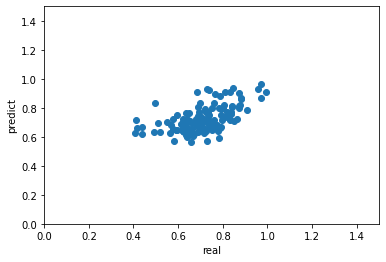

In [12]:
# 예측값과 실제값의 시각화
plt.scatter(y_test, y_predict)
plt.xlabel("real")
plt.ylabel("predict")
plt.xlim(0,1.5)
plt.ylim(0,1.5)

In [60]:
predict = result[result['시즌']==2021] # 2022년도 데이터 프레임
predict = pd.concat([predict, pd.get_dummies(predict['포지션'], drop_first=True)], axis=1) # 포지션 dummy variable로 변환

In [61]:
X = predict[X_cols] # 사용 feature
X = X.fillna(-1) # NA값 -1로 impute

In [72]:
# 예측
predict['y_hat'] = model.predict(X)
new = ['이름','생일','팀','시즌','포지션','y_hat']


In [76]:
# 타자별 예측값 feature에 저장
final = predict[new]
a=result[result['시즌']==2022]


4316    1.854455
4318    1.742602
4324    1.373487
4330    0.909297
4339    1.267227
          ...   
5040   -1.389280
5045   -1.853470
5048   -1.109648
5052   -1.327761
5058   -1.115240
Name: OPS, Length: 186, dtype: float64

In [74]:
# 제출 파일 생성
final.to_csv("/content/tnt_submission.csv", index=False, encoding='utf-8')

In [75]:
# 제출 결과 확인
sub = pd.read_csv('/content/tnt_submission.csv')
sub

,이름,생일,팀,시즌,포지션,y_hat
0,홍창기,1993-11-21,L,2021,CF,0.812279
1,이정후,1998-08-20,키,2021,CF,0.838670
2,강백호,1999-07-29,K,2021,1B,1.000448
3,최정,1987-02-28,S,2021,3B,0.881430
4,양의지,1987-06-05,N,2021,DH,0.868420
...,...,...,...,...,...,...
187,박정현,2001-07-27,한,2021,SS,0.615148
188,이원석,1999-03-31,한,2021,CF,0.604312
189,유장혁,2000-05-30,한,2021,CF,0.610636
190,예진원,1999-03-16,키,2021,CF,0.604312
